In [12]:
import numpy as np
import torch
import torchvision.transforms as transforms
import lightning as L
from pytorch_lightning.callbacks import Callback
from torchvision.models import vit_b_16, vit_b_32 # pretrained model
import torchmetrics
import cv2
import optuna
import albumentations as A

import brain_tumor_dataset as btd

# Data Augmentation

| **Augmentation**               | **Why Use It?**                                                                                           |
|---------------------------------|----------------------------------------------------------------------------------------------------------|
| **Rotate**                     | Simulates orientation differences.                                                                       |
| **Horizontal**				 | Increases diversity while retaining symmetry.                                                           |
| **Random Crop**                | Focuses on smaller regions of interest.                                                                 |
| **Elastic Transform**          | Introduces non-rigid variations.                                                                        |
| **Brightness/Contrast Adjustment** | Mimics scanner variability.                                                                             |
| **CLAHE**                      | Enhances local contrast, highlighting subtle features.                                                  |
| **Gaussian Noise**             | Simulates noisy scans.                                                                                  |
| **Compression**                | Mimics lossy storage artifacts.                                                                         |
| **Coarse Dropout**             | Simulates signal loss or occluded areas.                                                                |


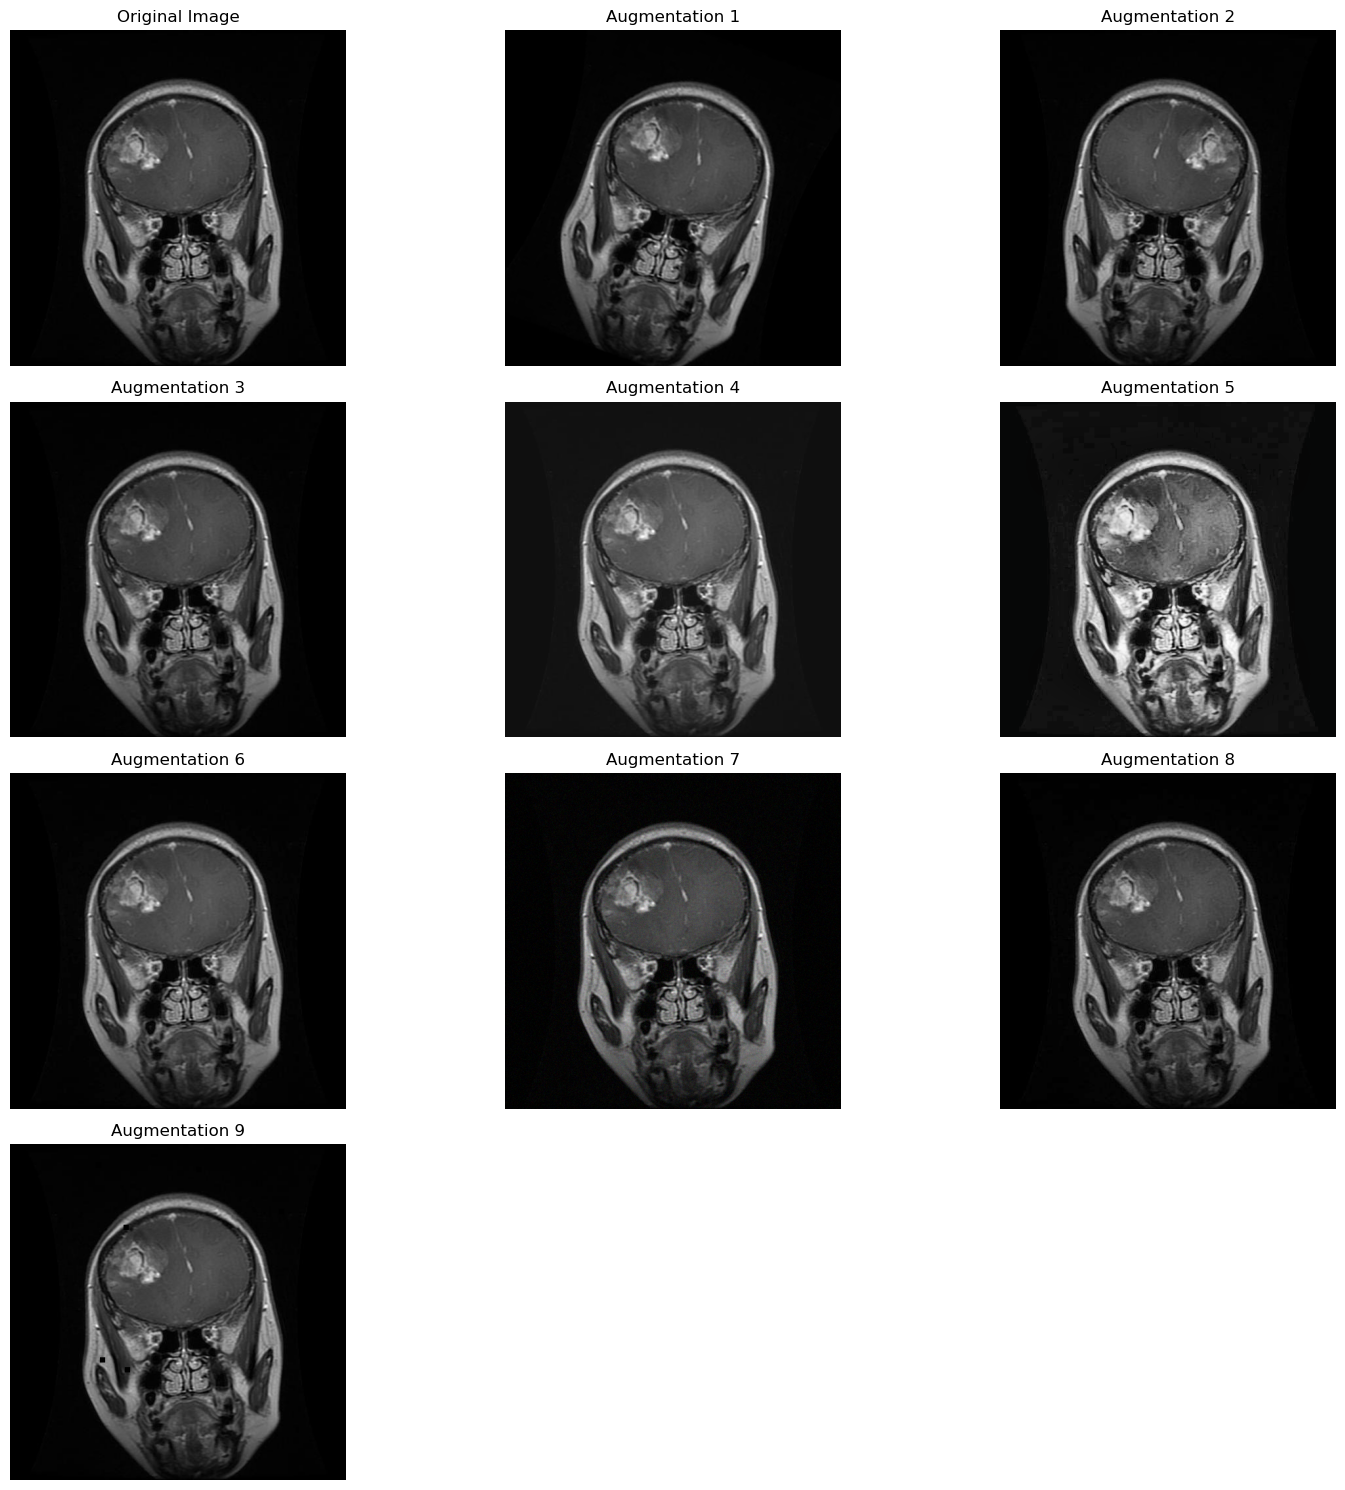

In [13]:
augmentations = A.Compose([
    # Geometric transformations
    A.Rotate(limit=30., border_mode=cv2.BORDER_CONSTANT, p=0.4), # Simulates slight differences in patient orientation during the scan.
    A.HorizontalFlip(p=0.6),  # Random horizontal flip
	A.ElasticTransform(alpha=1.0, sigma=50.0, p=0.2), # simulates the deformation of the brain tissue during the scan

	# intensity and contrast transformations
    A.RandomBrightnessContrast(p=0.4),  # Mimics variations in scanner settings or patient-specific image intensity
    A.CLAHE(p=.3),  # Contrast Limited Adaptive Histogram Equalization (to enhance local contrast)
    A.RandomGamma(p=.3),  # Random gamma adjustment for exposure variance
    
	# Noise and artifacts
    A.GaussNoise(p=.4),  # Simulates random noise in the image from the scanning process
    A.ImageCompression(quality_range=(60, 95), p=0.2),  # Simulates image compression artifacts
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),  # Simulates missing parts of the image
])

train_dataset = btd.BrainTumorDataset(btd.TRAIN_DATA_PATH)
btd.show_augmentations(train_dataset[0][0], augmentations)

In [ ]:
btd.augment_data(augmentations=augmentations,
                 file_path=btd.TRAIN_DATA_PATH,
                 num_augmentations=2,
                 overwrite=True)

Removed 5729 existing augmented images.


Processing images in C:\Users\NIels\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1\Training/: 0it [00:00, ?it/s]


Added 0 augmented images in C:\Users\NIels\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1\Training/.


Processing images in C:\Users\NIels\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1\Training/glioma: 100%|██████████| 1321/1321 [01:55<00:00, 11.40it/s]


Added 6605 augmented images in C:\Users\NIels\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1\Training/glioma.


Processing images in C:\Users\NIels\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1\Training/meningioma: 100%|██████████| 1339/1339 [01:57<00:00, 11.42it/s]


Added 6695 augmented images in C:\Users\NIels\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1\Training/meningioma.


Processing images in C:\Users\NIels\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1\Training/notumor: 100%|██████████| 1595/1595 [01:21<00:00, 19.56it/s]


Added 7975 augmented images in C:\Users\NIels\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1\Training/notumor.


Processing images in C:\Users\NIels\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1\Training/pituitary: 100%|██████████| 1457/1457 [02:22<00:00, 10.24it/s]

Added 7285 augmented images in C:\Users\NIels\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1\Training/pituitary.


# Setup the datamodule

In [16]:
class BrainTumorDataModule(L.LightningDataModule):
	def __init__(self, batch_size):
		super().__init__()
		self.batch_size = batch_size

	def setup(self, stage=None):
		transform = transforms.Compose([
			transforms.Grayscale(num_output_channels=3),   # convert to 3 channels
			transforms.ToTensor(),
			btd.CropImgTransform(),                		   # crop the image
			transforms.Resize((224, 224)),                 # resize to 224x224
		])

		self.train_dataset = btd.BrainTumorDataset(btd.TRAIN_DATA_PATH, transform=transform)
		self.test_dataset = btd.BrainTumorDataset(btd.TEST_DATA_PATH, transform=transform)

		val_size = len(self.test_dataset) // 2
		test_size = len(self.test_dataset) - val_size
		self.test_dataset, self.val_dataset = torch.utils.data.random_split(self.test_dataset, [test_size, val_size])

	def train_dataloader(self):
		return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

	def val_dataloader(self):
		return torch.utils.data.DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)

	def test_dataloader(self):
		return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

In [17]:
# test
dm = BrainTumorDataModule(1)
dm.setup()

# see len of datasets
print(len(dm.train_dataset), len(dm.val_dataset), len(dm.test_dataset))

34272 655 656


# Setup the classifier (LightningModule)

In [18]:
# Define the PyTorch Lightning Module
class BrainTumorClassifier(L.LightningModule):
	def __init__(self, 
			  	learning_rate=1e-4, 
				weight_decay=0.01,
				patch_size=16,
			  	pretrained_weights = "IMAGENET1K_V1",
				batch_size=-1): # -1 not specified and only for logging
		super().__init__()

		self.save_hyperparameters()  # Save hyperparameters for easy access

		# Initialize the model with the pre-trained ViT
		if patch_size == 16:
			self.model = vit_b_16(weights=pretrained_weights)
		elif patch_size == 32:
			self.model = vit_b_32(weights=pretrained_weights)
			
		self.model.heads = torch.nn.Linear(self.model.hidden_dim, 4)  # Modify for 4 classes

		# Define loss function
		self.criterion = torch.nn.CrossEntropyLoss()

		# Initialize accuracy metric for logging
		self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=4)
		self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=4)

		self.attention_maps = {}  # To store attention maps

	def forward(self, x):
		return self.model(x)

	def training_step(self, batch, batch_idx):
		inputs, labels = batch
		outputs = self(inputs)
		loss = self.criterion(outputs, labels)

		# Log loss and accuracy
		self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
		self.train_accuracy(outputs, labels)
		self.log('train_acc', self.train_accuracy, on_step=True, on_epoch=True, prog_bar=True)

		return loss
	
	def validation_step(self, batch, batch_idx):
		inputs, labels = batch
		outputs = self(inputs)
		loss = self.criterion(outputs, labels)

		# Log loss and accuracy
		self.log('val_loss', loss)
		self.val_accuracy(outputs, labels)
		self.log('val_acc', self.val_accuracy)

		return loss

	def test_step(self, batch, batch_idx):
		inputs, labels = batch
		outputs = self(inputs)
		loss = self.criterion(outputs, labels)

		# Log loss and accuracy
		self.log('test_loss', loss)
		self.val_accuracy(outputs, labels)
		self.log('test_acc', self.val_accuracy)

		self.log_attention_maps(inputs, labels, outputs, batch_idx)  # Save attention maps

		return loss
	
	def configure_optimizers(self):
		return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate, weight_decay=self.hparams.weight_decay)
	
	def register_attention_hooks(self):
		"""Register hooks to capture attention maps."""
		self.attention_maps.clear()  # Reset attention maps

		def hook_fn(module, input, output, module_name):
			module_name = module_name.split(".")[2]  # Get the layer name
			# inside vision_transformer.py, change the forward function of EncoderBlock to 
			# x, _ = self.self_attention(x, x, x, need_weights=True) | and set need_weights=True not False
			self.attention_maps[module_name] = output[1]  # Save the attention map

		# Register hooks on all MultiheadAttention layers
		for i, module in self.model.named_modules():
			if isinstance(module, torch.nn.MultiheadAttention):
				module.register_forward_hook(lambda module, input, output, module_name=i: hook_fn(module, input, output, module_name))
	
	def on_test_start(self):
		# Register the hook to each multi-head attention layer before testing
		self.register_attention_hooks()

	def log_attention_maps(self, inputs, labels, output, batch_idx):
			"""Log attention maps overlaid on the original image using Lightning's logger."""
			
			predicted_labels = [btd.BrainTumorDataset().idx_to_class[lbl.item()] for lbl in torch.argmax(output, dim=1)]
			batch_size = inputs.size(0)
			for i in range(batch_size):
				rollout_attention_map = torch.eye(self.attention_maps['encoder_layer_1'].size(-1))
				for _, attention in self.attention_maps.items():
					# Get the attention map for the first image in the batch
					attention_map = attention[i]  # Shape: [num_tokens, embedding_size]
     
					attention_map = attention_map + torch.eye(attention_map.size(-1))  # Add identity matrix
					attention_map /= attention_map.sum(dim=-1, keepdim=True)  # Normalize attention map
					if rollout_attention_map is None:
						rollout_attention_map = attention_map
					else:
						rollout_attention_map = torch.matmul(rollout_attention_map, attention_map)

				# Compute cosine similarity between class token and patches
				# class_token_embedding = class_token_embedding / torch.norm(class_token_embedding)
				num_patches_side = int((attention_map.size(0) - 1) ** 0.5)
				class_token_embedding = rollout_attention_map[0, 1:] # Shape: (embedding_size)
				attention_map = 1 - class_token_embedding.view(num_patches_side, num_patches_side, -1).clone()
				attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())
				# average_attention_map = average_attention_map / num_layers

				average_attention_map = attention_map.cpu().detach().numpy()
				average_attention_map = cv2.resize(average_attention_map, (inputs.size(2), inputs.size(3)))
				heatmap = cv2.applyColorMap(np.uint8(255 * average_attention_map), cv2.COLORMAP_JET)

				# Overlay the heatmap on the original image
				image = inputs[i].cpu().numpy().transpose(1, 2, 0)
				image = (image*255).astype(np.uint8)
				overlayed_image = cv2.addWeighted(image, 0.8, heatmap, 0.4, 0)

				# add class label
				label = labels[i].item()
				label = btd.BrainTumorDataset().idx_to_class[label]
				cv2.putText(overlayed_image, f"Real class: {label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
				cv2.putText(overlayed_image, f"Predicted class: {predicted_labels[i]}", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

				# convert to chw
				overlayed_image = overlayed_image.transpose(2, 0, 1)

				# log to tensorboard
				self.logger.experiment.add_image(f'attn_map/batch_{batch_idx}/img_{i}', overlayed_image, self.current_epoch)

# Training (using Optuna) 
Based on [this guide](https://medium.com/swlh/optuna-hyperparameter-optimization-in-pytorch-9ab5a5a39e77)

In [19]:
class OptunaReportCallback(Callback):
    def __init__(self, trial):
        self.trial = trial

    def on_validation_end(self, trainer, pl_module):
        val_loss = trainer.callback_metrics.get("val_loss")
        if val_loss is not None:
            val_loss = val_loss.item()
            self.trial.report(val_loss, step=trainer.global_step)
            if self.trial.should_prune():
                raise optuna.TrialPruned()

In [ ]:
# Define the objective function for Optuna (the function to optimize)
def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    patch_size = trial.suggest_categorical('patch_size', [16, 32])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Create the model and data module with suggested hyperparameters
    model = BrainTumorClassifier(learning_rate=learning_rate, 
                                 weight_decay=weight_decay,
                                 patch_size=patch_size,
                                 batch_size=batch_size)
    data_module = BrainTumorDataModule(batch_size=batch_size)

    # Define callbacks
    checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
        monitor="val_loss",
        mode="min",
        dirpath="checkpoints/",
        filename="epoch-{epoch:02d}-val_loss-{val_loss:.2f}",
        save_top_k=1,
    )

    early_stopping_callback = L.pytorch.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        mode="min",
        verbose=True,
    )

    logger = L.pytorch.loggers.TensorBoardLogger("logs", name="vit_pretrained")
    
    optuna_report_callback = OptunaReportCallback(trial)

    # Define the PyTorch Lightning Trainer
    trainer = L.Trainer(
        max_epochs=5,
        accelerator="auto",
        logger=logger,
        callbacks=[checkpoint_callback, early_stopping_callback, optuna_report_callback],
        val_check_interval=0.25,  
    )

    # Train the model
    trainer.fit(model, datamodule=data_module)

    # Evaluate the model
    val_loss = trainer.callback_metrics["val_loss"].item()

    # report intermediate objective value
    trial.report(val_loss, step=trainer.current_epoch)

    # Handle pruning based on the intermediate value
    if trial.should_prune():
        raise optuna.TrialPruned()

    return val_loss

In [ ]:
# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction="minimize", study_name="vit_pretrained")
study.optimize(objective, n_trials=10, show_progress_bar=True, n_jobs=-1)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

In [ ]:
import joblib # Save the study
import time 

now = time.strftime("%Y-%m-%d-%H-%M")
study_name = f"vit_pretrained_study_{now}.pkl"
joblib.dump(study, study_name)

['vit_pretrained_study_2024-12-01-14-36.pkl']

In [ ]:
study = joblib.load(study_name)  # Load the study

# Model testing

In [ ]:
# Test the model
# trainer.test(model, datamodule=data_module)

# Inspection of Optuna Study

In [14]:
# to load it:
# https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html
import joblib
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate

jl = joblib.load("logs/vit_pretrained_study.pkl")
print(jl.best_trial.params)

{'learning_rate': 0.00013740863973511956, 'weight_decay': 0.006504561649198227, 'patch_size': 16, 'batch_size': 32}


In [2]:
plot_optimization_history(jl)

In [ ]:
plot_parallel_coordinate(jl)

In [13]:
from optuna.visualization import plot_param_importances
plot_param_importances(jl)